<a href="https://colab.research.google.com/github/vidhi-sys/Intelligent-Object-Recognition-and-Query-System-for-Warehouse-Robotics/blob/main/CV_PART1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This module detects warehouse objects using color-based segmentation and contour analysis. The system converts input frames from BGR to HSV color space because HSV separates chromatic information from intensity, making it more robust to lighting variations commonly found in warehouse environments.

A predefined HSV range corresponding to brown cardboard colors is used to generate a binary mask. Morphological closing operations reduce noise and fill small gaps in detected regions. Contours are then extracted from the processed mask using OpenCV’s findContours function.

To eliminate small false detections, contours with an area below a threshold are ignored. For each valid contour, a bounding rectangle is computed using boundingRect, which provides width and height in pixels. The center coordinates are calculated as:

cx = x + w/2
cy = y + h/2

These values simulate spatial awareness required by a warehouse robot for grasp planning.

The system displays:

Bounding boxes

Pixel dimensions

Center point markers

Limitations include sensitivity to lighting extremes and difficulty distinguishing similarly colored objects. Future improvements could include edge-based detection or deep learning object detectors such as YOLO for greater robustness.


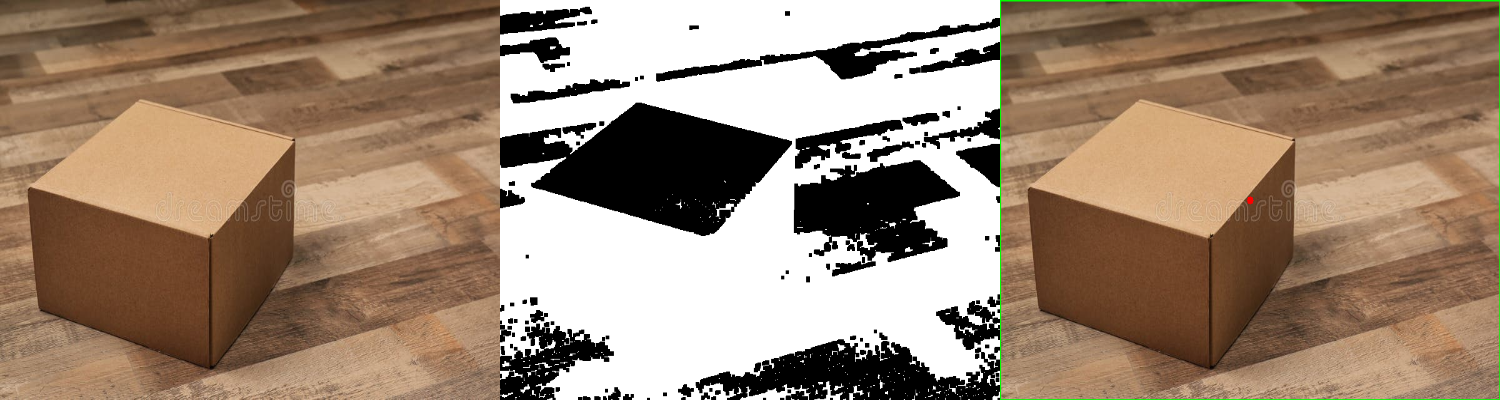

In [5]:
import cv2
import numpy as np
import requests # Import requests library
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab compatibility

def detect_objects(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Brown color range (adjust if needed)
    lower_brown = np.array([10, 100, 20])
    upper_brown = np.array([25, 255, 200])

    mask = cv2.inRange(hsv, lower_brown, upper_brown)

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    output = frame.copy()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        if cv2.contourArea(cnt) > 1000:
            x, y, w, h = cv2.boundingRect(cnt)

            cx = x + w // 2
            cy = y + h // 2

            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(output, f"W:{w}px H:{h}px", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(output, (cx, cy), 5, (0, 0, 255), -1)

    return mask, output


# URL of the image
image_url = "https://thumbs.dreamstime.com/b/cardboard-box-wooden-floor-cardboard-box-floor-114817500.jpg"

# Download the image using requests and convert to numpy array
try:
    resp = requests.get(image_url, stream=True).raw
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
except Exception as e:
    print(f"Error loading image from URL: {e}")
    image = None # Ensure image is None if loading fails

# Check if image loaded successfully before processing
if image is not None:
    mask, detected = detect_objects(image)

    # Convert mask to 3-channel so it can stack with color images
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Resize for consistent display (optional)
    image = cv2.resize(image, (500, 400))
    mask_3ch = cv2.resize(mask_3ch, (500, 400))
    detected = cv2.resize(detected, (500, 400))

    # Stack horizontally
    combined = np.hstack((image, mask_3ch, detected))

    cv2_imshow(combined) # Use cv2_imshow for Colab
else:
    print("Image could not be loaded. Please check the URL or your network connection.")
